In [56]:
import sys
sys.path.append('../..')
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import ta
import numpy as np
import datetime
from IPython.display import clear_output
from utilities.data_manager import ExchangeDataManager
from utilities.custom_indicators import get_n_columns, Trix
from utilities.bt_analysis import get_metrics, backtest_analysis
from utilities.plot_analysis import plot_equity_vs_asset, plot_futur_simulations, plot_bar_by_month
import nest_asyncio
nest_asyncio.apply()

In [57]:
exchange_name = "binance"
leverage = 1
start_date = "2020-01-01"
end_date = None
strategy_type = ["long"]


dict_params = {
    "1h": {
        "p1": {
            "BTC/USDT": {
                "trix_length": 19,
                "trix_signal_length": 15,
                "trix_signal_type": "sma",
                "long_ma_length": 500,
            },
            "ETH/USDT": {
                "trix_length": 21,
                "trix_signal_length": 9,
                "trix_signal_type": "ema",
                "long_ma_length": 500,
            },
            "SOL/USDT": {
                "trix_length": 11,
                "trix_signal_length": 9,
                "trix_signal_type": "sma",
                "long_ma_length": 500,
            },
        },
        "p2": {
            "BTC/USDT": {
                "trix_length": 13,
                "trix_signal_length": 41,
                "trix_signal_type": "sma",
                "long_ma_length": 500,
            },
            "ETH/USDT": {
                "trix_length": 13,
                "trix_signal_length": 37,
                "trix_signal_type": "ema",
                "long_ma_length": 500,
            },
            "SOL/USDT": {
                "trix_length": 9,
                "trix_signal_length": 23,
                "trix_signal_type": "sma",
                "long_ma_length": 500,
            },
        },
    },
    "2h": {
        "p1": {
            "BTC/USDT": {
                "trix_length": 7,
                "trix_signal_length": 11,
                "trix_signal_type": "ema",
                "long_ma_length": 300,
            },
            "ETH/USDT": {
                "trix_length": 21,
                "trix_signal_length": 47,
                "trix_signal_type": "sma",
                "long_ma_length": 300,
            },
            "SOL/USDT": {
                "trix_length": 5,
                "trix_signal_length": 5,
                "trix_signal_type": "ema",
                "long_ma_length": 300,
            },
        },
        "p2": {
            "BTC/USDT": {
                "trix_length": 41,
                "trix_signal_length": 7,
                "trix_signal_type": "ema",
                "long_ma_length": 300,
            },
            "ETH/USDT": {
                "trix_length": 39,
                "trix_signal_length": 7,
                "trix_signal_type": "sma",
                "long_ma_length": 300,
            },
            "SOL/USDT": {
                "trix_length": 47,
                "trix_signal_length": 47,
                "trix_signal_type": "ema",
                "long_ma_length": 300,
            },
        },
    },
    "4h": {
        "p1": {
            "BTC/USDT": {
                "trix_length": 11,
                "trix_signal_length": 45,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
            "ETH/USDT": {
                "trix_length": 19,
                "trix_signal_length": 7,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
            "SOL/USDT": {
                "trix_length": 41,
                "trix_signal_length": 7,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
        },
        "p2": {
            "BTC/USDT": {
                "trix_length": 5,
                "trix_signal_length": 7,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
            "ETH/USDT": {
                "trix_length": 9,
                "trix_signal_length": 47,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
            "SOL/USDT": {
                "trix_length": 25,
                "trix_signal_length": 41,
                "trix_signal_type": "ema",
                "long_ma_length": 200,
            },
        },
    },
}


oldest_pair = "1h-p1-BTC/USDT"

In [58]:
class Strategy:
    def __init__(
        self,
        df_list,
        oldest_pair,
        type=["long"],
        params={},
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.use_long = True if "long" in type else False
        self.use_short = True if "short" in type else False
        self.params = params

    def populate_indicators(self):
        for comb in self.df_list:
            params = self.params[comb]
            df = self.df_list[comb]
            df.drop(
                columns=df.columns.difference(
                    ["open", "high", "low", "close", "volume"]
                ),
                inplace=True,
            )

            # -- Populate indicators --

            trix_obj = Trix(
                close=df["close"],
                trix_length=params["trix_length"],
                trix_signal_length=params["trix_signal_length"],
                trix_signal_type=params["trix_signal_type"],
            )
            df["trix"] = trix_obj.get_trix_pct_line()
            df["trix_signal"] = trix_obj.get_trix_signal_line()
            df["trix_hist"] = df["trix"] - df["trix_signal"]

            df["long_ma"] = ta.trend.ema_indicator(
                df["close"], window=params["long_ma_length"]
            )

            self.df_list[comb] = df

        return self.df_list[self.oldest_pair]

    def populate_buy_sell(self):
        full_list = []
        for comb, df in self.df_list.items():
            params = self.params[comb]
            df["comb"] = comb
            full_list.append(df)

        df_full = pd.concat(full_list)
        df_full = df_full.sort_index()
        self.open_long_obj = (
            df_full[(df_full["trix_hist"] > 0) & (df_full["close"] > df_full["long_ma"])]
            .groupby("date")["comb"]
            .apply(list)
            .to_dict()
            if self.use_long
            else {}
        )
        self.close_long_obj = (
            df_full[(df_full["trix_hist"] < 0)]
            .groupby("date")["comb"]
            .apply(list)
            .to_dict()
            if self.use_long
            else {}
        )
        self.open_short_obj = (
            df_full[(df_full["trix_hist"] < 0) & (df_full["close"] < df_full["long_ma"])]
            .groupby("date")["comb"]
            .apply(list)
            .to_dict()
            if self.use_short
            else {}
        )
        self.close_short_obj = (
            df_full[(df_full["trix_hist"] > 0)]
            .groupby("date")["comb"]
            .apply(list)
            .to_dict()
            if self.use_short
            else {}
        )

        return self.df_list[self.oldest_pair]

    def run_backtest(self, initial_wallet=1000, leverage=1, start_date=None, end_date=None):
        if start_date is not None:
            self.df_list = {
                k: v[(v.index >= start_date)]
                for k, v in self.df_list.items()
            }
        if end_date is not None:
            self.df_list = {
                k: v[(v.index <= end_date)]
                for k, v in self.df_list.items()
            }
        params = self.params
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        long_exposition = 0
        short_exposition = 0
        maker_fee = 0.0002
        taker_fee = 0.0005
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}

        for index, ini_row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for comb in current_positions:
                    row = self.df_list[comb].loc[index]
                    position = current_positions[comb]
                    if position["side"] == "LONG":
                        close_price = row["open"]
                        trade_result = (close_price - position["price"]) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee
                    elif position["side"] == "SHORT":
                        close_price = row["open"]
                        trade_result = (position["price"] - close_price) / position[
                            "price"
                        ]
                        close_size = position["size"] + position["size"] * trade_result
                        fee = close_size * taker_fee
                        temp_wallet += close_size - position["size"] - fee

                days.append(
                    {
                        "day": str(index.year)
                        + "-"
                        + str(index.month)
                        + "-"
                        + str(index.day),
                        "wallet": temp_wallet,
                        "price": ini_row["open"],
                        "long_exposition": 0,
                        "short_exposition": 0,
                        "risk": 0,
                    }
                )
            previous_day = current_day

            close_long_row = (
                self.close_long_obj[index] if index in self.close_long_obj else []
            )
            close_short_row = (
                self.close_short_obj[index] if index in self.close_short_obj else []
            )
            if len(current_positions) > 0:
                # -- Close LONG --
                long_position_to_close = set(
                    {k: v for k, v in current_positions.items() if v["side"] == "LONG"}
                ).intersection(set(close_long_row))
                for comb in long_position_to_close:
                    row = self.df_list[comb].loc[index]
                    position = current_positions[comb]
                    close_price = row["close"]
                    trade_result = (close_price - position["price"]) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": comb,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del current_positions[comb]

                # -- Close SHORT --
                short_position_to_close = set(
                    {k: v for k, v in current_positions.items() if v["side"] == "SHORT"}
                ).intersection(set(close_short_row))
                for comb in short_position_to_close:
                    row = self.df_list[comb].loc[index]
                    position = current_positions[comb]
                    close_price = row["close"]
                    trade_result = (position["price"] - close_price) / position["price"]
                    close_size = position["size"] + position["size"] * trade_result
                    fee = close_size * taker_fee
                    wallet += close_size - position["size"] - fee
                    trades.append(
                        {
                            "pair": comb,
                            "open_date": position["date"],
                            "close_date": index,
                            "position": position["side"],
                            "open_reason": position["reason"],
                            "close_reason": "Market",
                            "open_price": position["price"],
                            "close_price": close_price,
                            "open_fee": position["fee"],
                            "close_fee": fee,
                            "open_trade_size": position["size"],
                            "close_trade_size": close_size,
                            "wallet": wallet,
                        }
                    )
                    del current_positions[comb]

            # -- Check for opening position --
            # -- Open LONG --
            open_long_row = (
                self.open_long_obj[index] if index in self.open_long_obj else []
            )
            for comb in open_long_row:
                if comb not in current_positions:
                    row = self.df_list[comb].loc[index]
                    open_price = row["close"]
                    pos_size = params[comb]["size"] * wallet * leverage
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[comb] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "LONG",
                    }
                    long_exposition += 0
            # -- Open SHORT --
            open_short_row = (
                self.open_short_obj[index] if index in self.open_short_obj else []
            )
            for comb in open_short_row:
                if comb not in current_positions:
                    row = self.df_list[comb].loc[index]
                    open_price = row["close"]
                    pos_size = params[comb]["size"] * wallet * leverage
                    fee = pos_size * taker_fee
                    pos_size -= fee
                    wallet -= fee
                    current_positions[comb] = {
                        "size": pos_size,
                        "date": index,
                        "price": open_price,
                        "fee": fee,
                        "reason": "Market",
                        "side": "SHORT",
                    }
                    short_exposition += 0

        if len(trades) == 0:
            raise ValueError("No trades have been made")

        df_days = pd.DataFrame(days)
        df_days["day"] = pd.to_datetime(df_days["day"])
        df_days = df_days.set_index(df_days["day"])

        df_trades = pd.DataFrame(trades)
        df_trades["open_date"] = pd.to_datetime(df_trades["open_date"])
        df_trades = df_trades.set_index(df_trades["open_date"])

        return get_metrics(df_trades, df_days) | {
            "wallet": wallet,
            "trades": df_trades,
            "days": df_days,
        }

In [59]:
exchange = ExchangeDataManager(
    exchange_name=exchange_name, path_download="../database/exchanges"
)


df_list = {}

total_size = sum(
    obj["size"]
    for timeframe in dict_params.values()
    for params in timeframe.values()
    for obj in params.values()
    if "size" in obj
)
if total_size > 1:
    print("Warning: Total size is greater than 1")

no_size_number = len(
    [
        obj
        for timeframe in dict_params.values()
        for params in timeframe.values()
        for obj in params.values()
        if "size" not in obj
    ]
)


params = {}

for tf in dict_params:
    for param in dict_params[tf]:
        for pair in dict_params[tf][param]:
            if "size" not in dict_params[tf][param][pair]:
                dict_params[tf][param][pair]["size"] = max(1-total_size, 0) / no_size_number

            params[f"{tf}-{param}-{pair}"] = dict_params[tf][param][pair]

            df = exchange.load_data(pair, tf)
            df["pair"] = pair
            df["tf"] = tf


            df_list[f"{tf}-{param}-{pair}"] = df.loc[:]



print("Data load 100%")


df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume,pair,tf
date,,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,BTC/USDT,1h
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,BTC/USDT,1h
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,BTC/USDT,1h
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,BTC/USDT,1h
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,BTC/USDT,1h
...,...,...,...,...,...,...,...
2024-09-11 09:00:00,56398.01,56741.24,56381.67,56677.99,797.078030,BTC/USDT,1h
2024-09-11 10:00:00,56678.00,56700.00,56328.26,56510.00,1570.347750,BTC/USDT,1h
2024-09-11 11:00:00,56510.00,56895.82,56507.39,56797.99,1155.699610,BTC/USDT,1h


In [60]:
strat = Strategy(
    df_list=df_list,
    oldest_pair=oldest_pair,
    type=strategy_type,
    params=params,
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, leverage=leverage, start_date=start_date, end_date=end_date)

df_trades, df_days = backtest_analysis(
    trades=bt_result["trades"],
    days=bt_result["days"],
    general_info=True,
    trades_info=True,
    days_info=True,
    long_short_info=True,
    entry_exit_info=True,
    exposition_info=False,
    pair_info=True,
    indepedant_trade=True,
)

Period: [2020-01-03 00:00:00] -> [2024-09-11 00:00:00]
Initial wallet: 1000.0 $

--- General Information ---
Final wallet: 19994.54 $
Performance: 1899.45 %
Sharpe Ratio: 2.35 | Sortino Ratio: 4.16 | Calmar Ratio: 2.65
Worst Drawdown T|D: -24.17% | -25.64%
Buy and hold performance: 727.45 %
Performance vs buy and hold: 141.64 %
Total trades on the period: 5831
Average Profit: 1.09 %
Global Win rate: 43.25 %

--- Trades Information ---
Mean Trades per day: 3.4
Mean Trades Duration: 1 days 12:05:59.320871205
Best trades: +140.75 % the 2021-01-27 08:00:00 -> 2021-02-13 20:00:00 (4h-p2-SOL/USDT)
Worst trades: -28.23 % the 2022-11-05 20:00:00 -> 2022-11-08 00:00:00 (4h-p2-SOL/USDT)
Total Good trades on the period: 2522
Total Bad trades on the period: 3309
Average Good Trades result: 5.73 %
Average Bad Trades result: -2.46 %
Mean Good Trades Duration: 2 days 04:07:31.070578905
Mean Bad Trades Duration: 0 days 23:53:08.757932910

--- Days Informations ---
Total: 1714 days recorded
Winning day

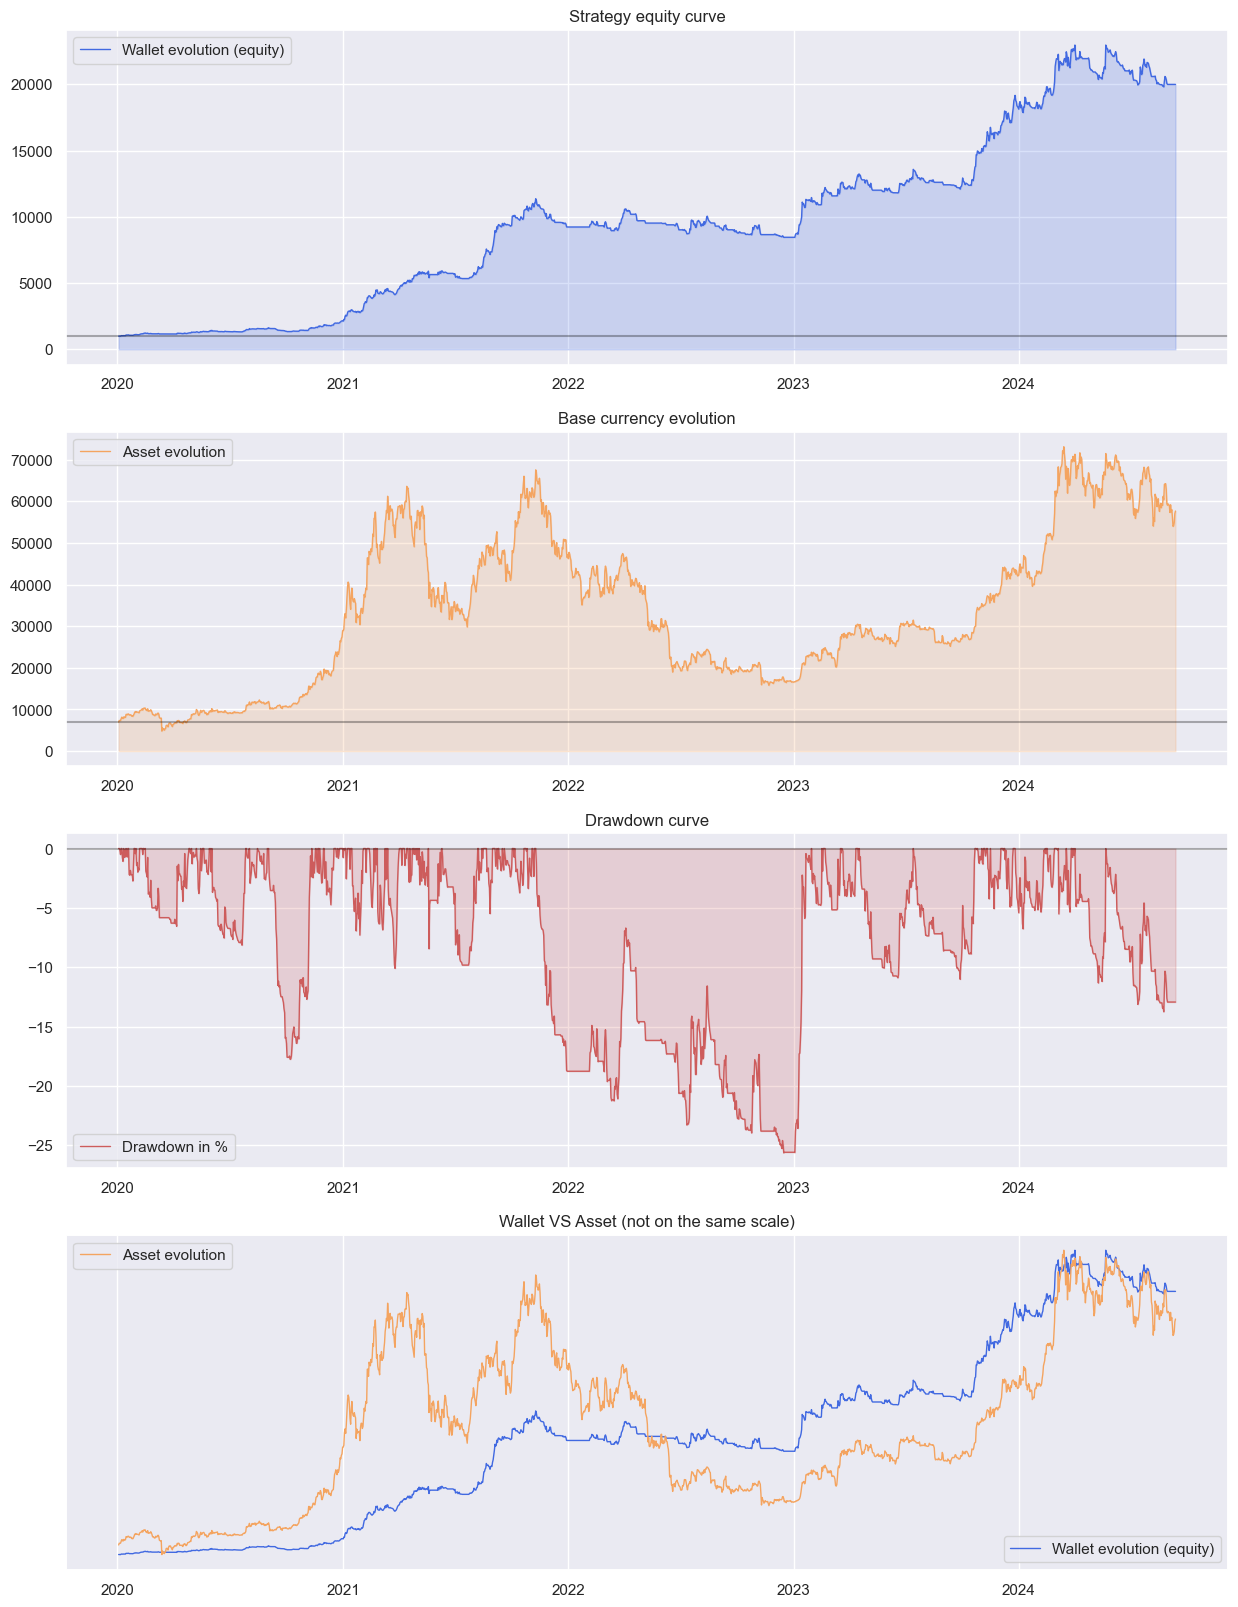

In [61]:
plot_equity_vs_asset(df_days=df_days.loc[:])

In [62]:
df_trades

,pair,open_date,close_date,position,open_reason,close_reason,open_price,close_price,open_fee,close_fee,open_trade_size,close_trade_size,wallet,trade_result,trade_result_pct,trade_result_pct_wallet,trades_duration,wallet_ath,drawdown,drawdown_pct
open_date,,,,,,,,,,,,,,,,,,,,
2020-01-03 08:00:00,2h-p1-BTC/USDT,2020-01-03 08:00:00,2020-01-04 08:00:00,LONG,Market,Market,7348.42,7363.88,0.027778,0.027822,55.527778,55.644600,999.839028,0.089045,0.001604,0.000089,1 days 00:00:00,999.839028,0.000000,0.000000
2020-01-03 08:00:00,1h-p1-BTC/USDT,2020-01-03 08:00:00,2020-01-04 10:00:00,LONG,Market,Market,7260.60,7318.30,0.027777,0.027984,55.526235,55.967502,1000.252311,0.413490,0.007447,0.000413,1 days 02:00:00,1000.252311,0.000000,0.000000
2020-01-03 13:00:00,1h-p1-ETH/USDT,2020-01-03 13:00:00,2020-01-04 14:00:00,LONG,Market,Market,133.54,133.06,0.027774,0.027660,55.520066,55.320503,1000.025088,-0.227337,-0.004095,-0.000227,1 days 01:00:00,1000.252311,0.227223,0.000227
2020-01-03 13:00:00,1h-p2-ETH/USDT,2020-01-03 13:00:00,2020-01-04 14:00:00,LONG,Market,Market,133.54,133.06,0.027775,0.027661,55.521608,55.322040,999.797858,-0.227343,-0.004095,-0.000227,1 days 01:00:00,1000.252311,0.454453,0.000454
2020-01-03 08:00:00,1h-p2-BTC/USDT,2020-01-03 08:00:00,2020-01-04 15:00:00,LONG,Market,Market,7260.60,7318.99,0.027775,0.027985,55.523151,55.969670,1000.216393,0.418744,0.007542,0.000418,1 days 07:00:00,1000.252311,0.035918,0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-27 07:00:00,1h-p2-SOL/USDT,2024-08-27 07:00:00,2024-08-27 09:00:00,LONG,Market,Market,157.72,156.51,0.562361,0.557768,1124.159863,1115.535507,20220.375689,-9.186717,-0.008172,-0.000455,0 days 02:00:00,22641.272873,2420.897184,0.106924
2024-08-27 04:00:00,1h-p1-SOL/USDT,2024-08-27 04:00:00,2024-08-27 10:00:00,LONG,Market,Market,158.57,153.62,0.562377,0.544549,1124.191091,1089.097783,20184.737832,-35.655685,-0.031717,-0.001770,0 days 06:00:00,22641.272873,2456.535042,0.108498
2024-08-23 18:00:00,2h-p2-SOL/USDT,2024-08-23 18:00:00,2024-08-28 16:00:00,LONG,Market,Market,149.70,142.16,0.550795,0.522791,1101.039126,1045.582647,20128.758561,-56.007275,-0.050868,-0.002790,4 days 22:00:00,22641.272873,2512.514313,0.110971


----- 2020 Cumulative Performances: 114.71% -----


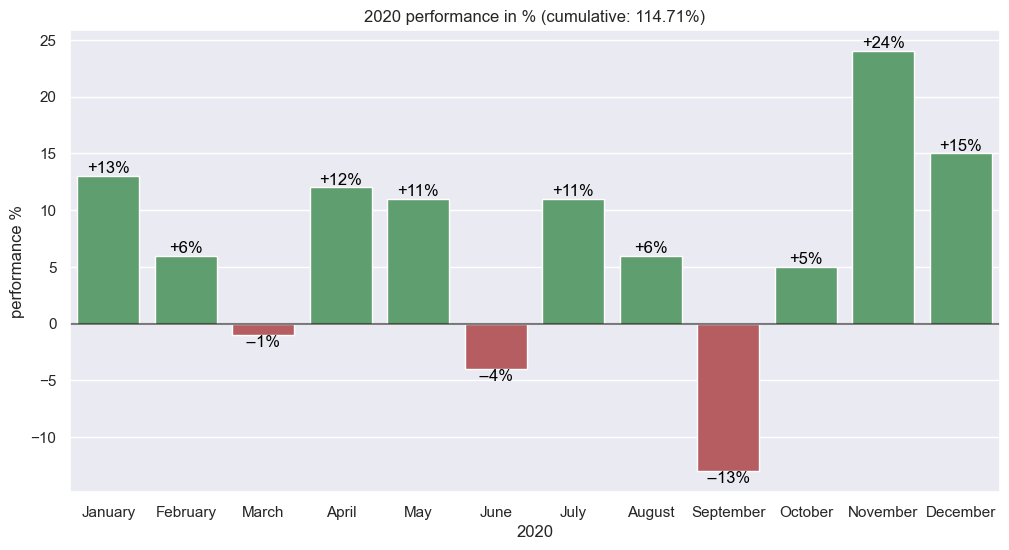

----- 2021 Cumulative Performances: 333.41% -----


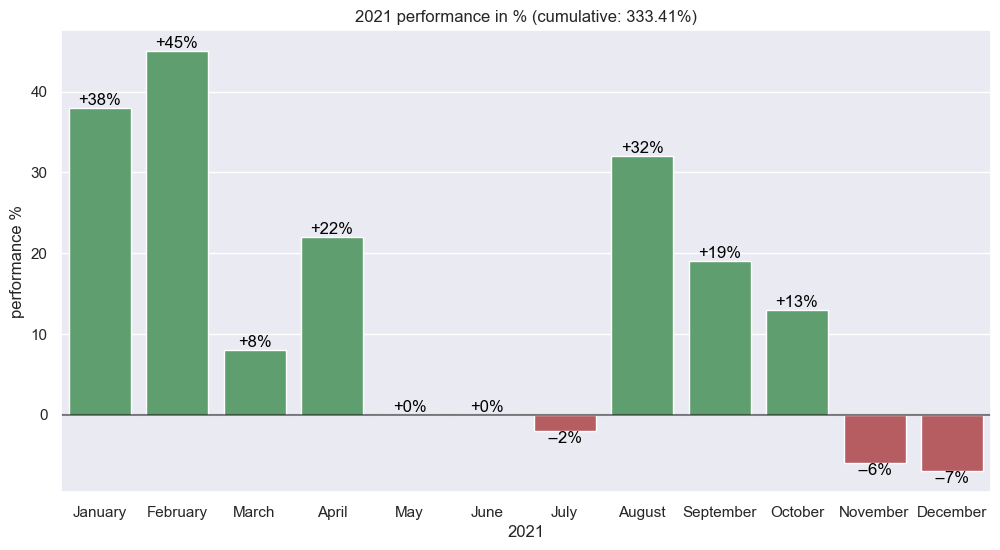

----- 2022 Cumulative Performances: -8.4% -----


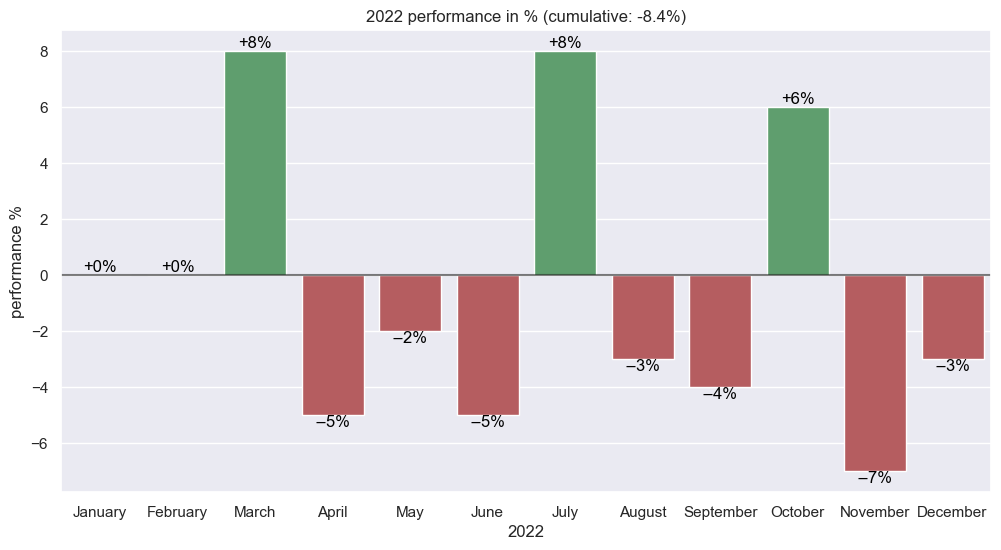

----- 2023 Cumulative Performances: 115.47% -----


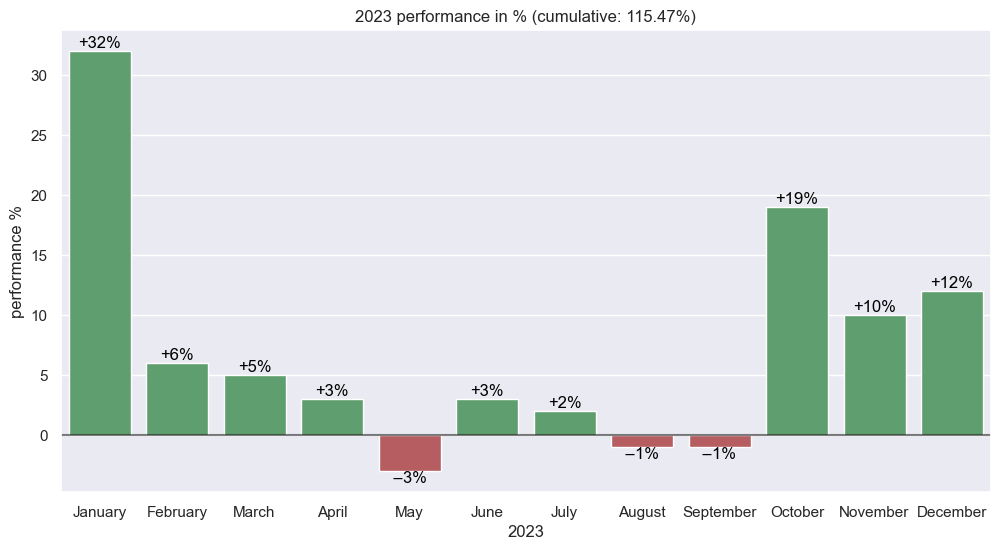

----- 2024 Cumulative Performances: 10.3% -----


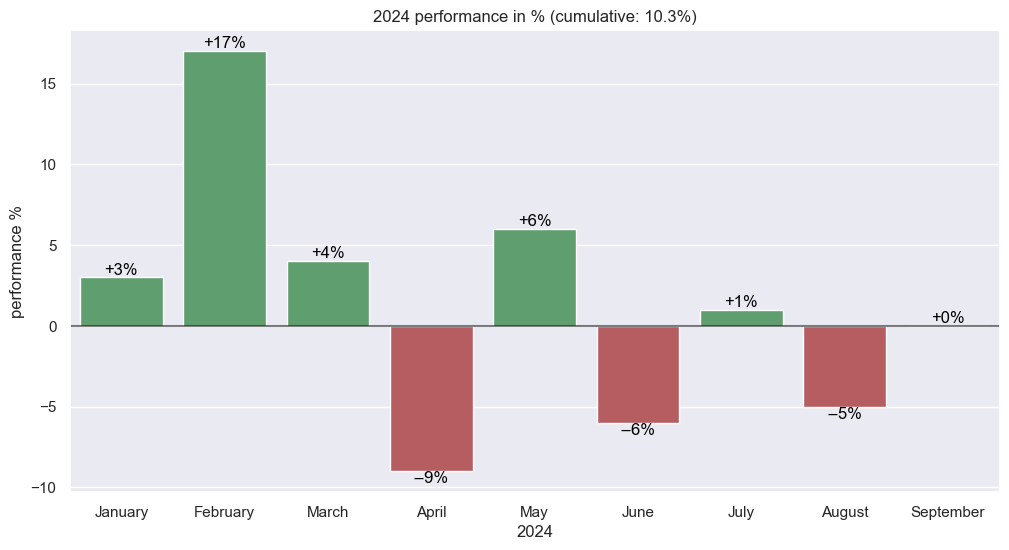

In [63]:
plot_bar_by_month(df_days=df_days)

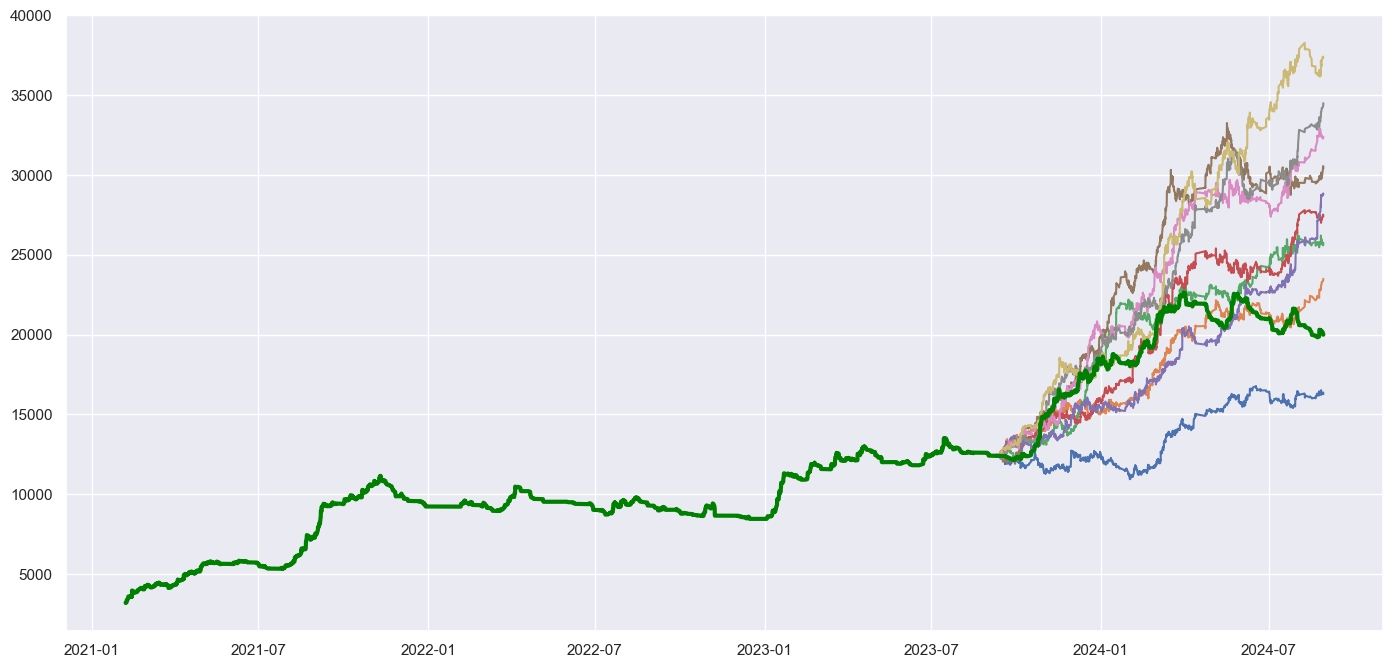

In [65]:
from utilities.plot_analysis import plot_train_test_simulation


plot_train_test_simulation(df_trades, "2023-09-10", 2, 1000)